In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


#text preprocessing
import re
import string
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer

#plots
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


#modeling stuff

import torch
import copy
from tqdm import tqdm
from torch import nn,optim
from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
import optuna
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score

#set fixed random seed for coherent results
import random

seed_val = 3
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [2]:
#import the datasets

train= pd.read_csv('nlp-getting-started/train.csv')
test= pd.read_csv("nlp-getting-started/test.csv")

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
text=train['text']
label=train['target']

In [6]:
def clean_text(text):

    # Expanding chatwords and contracts clearing contractions
    mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot",
               "'cause": "because", "could've": "could have", "couldn't": "could not",
               "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
               "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will",
               "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
               "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
               "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
               "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
               "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
               "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
               "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not",
               "might've": "might have","mightn't": "might not","mightn't've": "might not have",
               "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
               "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
               "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
               "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would",
               "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
               "she's": "she is", "should've": "should have", "shouldn't": "should not",
               "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is",
               "that'd": "that would", "that'd've": "that would have", "that's": "that is",
               "there'd": "there would", "there'd've": "there would have", "there's": "there is",
               "here's": "here is","they'd": "they would", "they'd've": "they would have",
               "they'll": "they will", "they'll've": "they will have", "they're": "they are",
               "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
               "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
               "we're": "we are", "we've": "we have", "weren't": "were not",
               "what'll": "what will", "what'll've": "what will have","what're": "what are",
               "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have",
               "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
               "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is",
               "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
               "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
               "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
               "y'all're": "you all are","y'all've": "you all have","you'd": "you would",
               "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
               "you're": "you are", "you've": "you have" }



    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])     #apply mapping to the tweets

    text = BeautifulSoup(text).get_text()    #remove HTML tags

    text=re.sub('[\w\.-]+@[\w\.-]+\.\w+', ' ', text)    #remove emails

    emoji_clean= re.compile("["
                            u"\U0001F600-\U0001F64F"  # emoticons
                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            "]+", flags=re.UNICODE)
    text = emoji_clean.sub(r'',text)

    text = re.sub(r"mh370", "missing malaysia airlines flight", text) #the next rows are used to expand common achronims
    text = re.sub(r"okwx", "oklahoma city weather", text)
    text = re.sub(r"arwx", "arkansas weather", text)
    text = re.sub(r"gawx", "georgia weather", text)
    text = re.sub(r"scwx", "south carolina weather", text)
    text = re.sub(r"cawx", "california weather", text)
    text = re.sub(r"tnwx", "tennessee weather", text)
    text = re.sub(r"azwx", "arizona weather", text)
    text = re.sub(r"alwx", "alabama Weather", text)
    text = re.sub(r"wordpressdotcom", "wordpress", text)
    text = re.sub(r"usnwsgov", "united states national weather service", text)
    text = re.sub(r"suruc", "sanliurfa", text)

    text = re.sub(r'https?://(www\.)?(\w+)(\.\w+)(/\w*)?', '', text)     # Remove urls

    text = re.sub('\w*\d\w*', '', text)     # Remove words with numbers

    text = "".join([word.lower() for word in text if word not in string.punctuation]) # Remove punctuation

    stop_words = set(stopwords.words('english'))
    text=' '.join([word for word in text.split() if word.isalpha() and word not in stop_words])   # Remove stopwords

    text = re.sub(' +', ' ', text).strip()            #removes extra spaces

    return text

In [7]:
#example of cleaning text

clean_text("    Check these out: http://t.co/rOI2NSmEJJ, #hurricane")

/Users/ceyhun/opt/anaconda3/envs/Dataspell_1_env/lib/python3.8/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


'check hurricane'

In [8]:
#applying the cleaning to the texts

text=text.apply(clean_text)
text

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2       residents asked shelter place notified officer...
3       people receive wildfires evacuation orders cal...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7608    two giant cranes holding bridge collapse nearb...
7609    ariaahrary thetawniest control wild fires cali...
7610                                   utc volcano hawaii
7611    police investigating ebike collided car little...
7612    latest homes razed northern california wildfir...
Name: text, Length: 7613, dtype: object

In [9]:
df = pd.DataFrame()
df['text']=text
df['label']=label
df.shape

(7613, 2)

In [10]:
#no data is null
df.isnull().sum()

text     0
label    0
dtype: int64

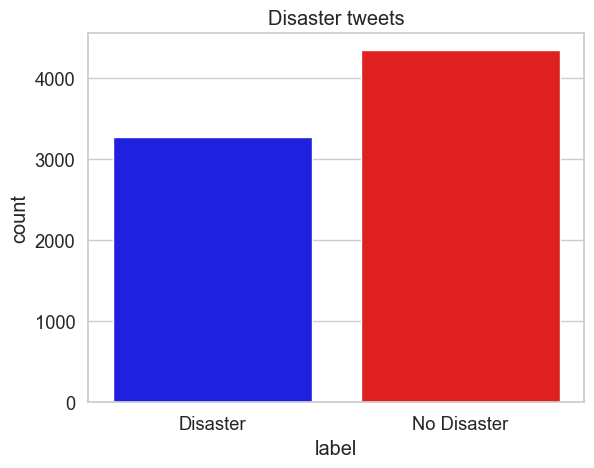

In [11]:
sns.set(style='whitegrid', font_scale=1.2)
sns.countplot(x =df.label, palette=['blue', 'red'], order=[1,0])
plt.xticks(ticks=np.arange(2), labels=['Disaster','No Disaster'])
plt.title('Disaster tweets')
plt.show()

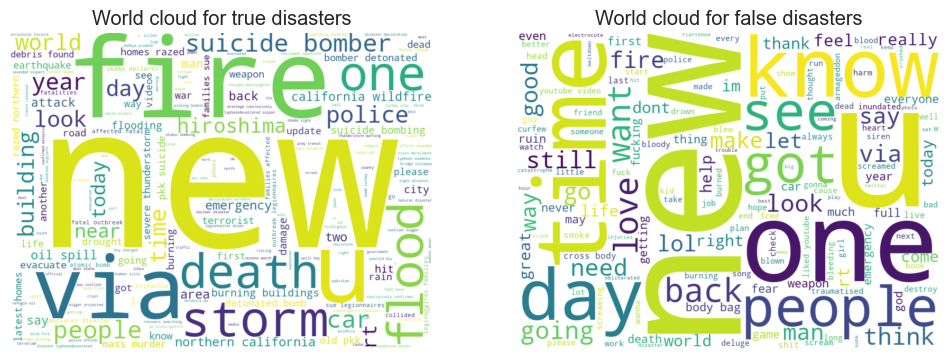

In [12]:
# Word clouds for true and false disasters
positive_data = df[df.label == 1]['text']
positive_data_string = ' '.join(positive_data)
wcp = WordCloud(max_words=200, width=800, height=600, background_color="white").generate(positive_data_string)


negative_data = df[df.label == 0]['text']
negative_data_string = ' '.join(negative_data)
wcn = WordCloud(max_words=150, width=800, height=600, background_color="white").generate(negative_data_string)

fig, (fig1, fig2) = plt.subplots(1,2, figsize=(12, 12))

fig1.imshow(wcp, interpolation='bilinear')
fig1.set_title('World cloud for true disasters')
fig1.axis('off')

fig2.imshow(wcn, interpolation='bilinear')
fig2.set_title('World cloud for false disasters')
fig2.axis('off')

plt.show()

<Axes: xlabel='len', ylabel='Count'>

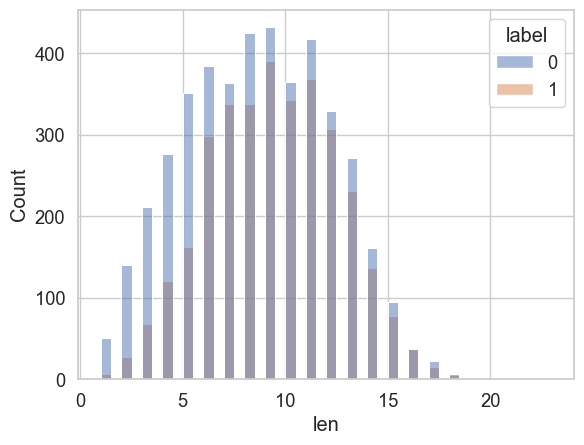

In [13]:
#difference in length between disaster reviews and not

df['len']=df['text'].str.split().map(lambda x: len(x))

sns.histplot(data=df, x='len', hue="label")

In [14]:
df

,text,label,len
0,deeds reason earthquake may allah forgive us,1,7
1,forest fire near la ronge sask canada,1,7
2,residents asked shelter place notified officer...,1,11
3,people receive wildfires evacuation orders cal...,1,6
4,got sent photo ruby alaska smoke wildfires pou...,1,9
...,...,...,...
7608,two giant cranes holding bridge collapse nearb...,1,8
7609,ariaahrary thetawniest control wild fires cali...,1,11
7610,utc volcano hawaii,1,3
7611,police investigating ebike collided car little...,1,14


In [15]:
# Splitting into train and validation
validation_size = 0.15

train, val = train_test_split(df, test_size=validation_size)

In [16]:
# Defining Vocabulary
maxlen = 0
vocab = {"PAD": 0, "UNK": 1}
for rev in train['text']:
    if len(rev.split()) > maxlen:
        maxlen = len(rev.split())
    for word in rev.split():
        if word not in vocab:               # word has not been assigned an index yet
            vocab[word] = len(vocab)        # Assign each word with a unique index

print(maxlen, len(vocab))

23 14616


In [17]:
text

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2       residents asked shelter place notified officer...
3       people receive wildfires evacuation orders cal...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7608    two giant cranes holding bridge collapse nearb...
7609    ariaahrary thetawniest control wild fires cali...
7610                                   utc volcano hawaii
7611    police investigating ebike collided car little...
7612    latest homes razed northern california wildfir...
Name: text, Length: 7613, dtype: object

In [18]:
#One hot encoding for both the train and the validation dataset

def prepare_sequence(text, vocab, maxlen):
    idxs = [vocab[w] if w in vocab else vocab["UNK"] for w in text.split()]
    idxs = [idxs[i] if i < len(idxs) else vocab["PAD"] for i in range(maxlen)]

    return torch.tensor(idxs, dtype=torch.long)

In [19]:
class TweetDisasterDataset(Dataset):

    def __init__(self, df, vocab, maxlen):
        super(TweetDisasterDataset, self).__init__()

        self.text = df.text.apply(prepare_sequence, args=(vocab, maxlen)).tolist()
        self.label = df.label.tolist()


    def __getitem__(self, index):
        return self.text[index], self.label[index]

    def __len__(self):
        return len(self.label)

    def get_sentiment(self):
        return self.label

trainset = TweetDisasterDataset(train, vocab, maxlen)
valset = TweetDisasterDataset(val, vocab, maxlen)

In [20]:
#general model to train the classifiers and show informations, pytorch based

class GeneralModel(nn.Module):

    def train_classifier(self, trainloader, valloader, epochs, criterion, optimizer, device, tune=False):
        train_losses = []
        train_accs = []
        val_losses = []
        val_accs = []

        best_epoch = 0
        best_loss = np.Inf
        best_acc = 0
        for ep in (range(epochs) if not tune else tqdm(range(epochs))):
            self.train()
            running_loss = 0.0
            acc = 0
            total = 0

            for it, (revs, labels) in enumerate(tqdm(trainloader) if not tune else trainloader):

                revs = revs.to(device)
                labels = labels.to(device)

                # Forward pass
                logits = self.forward(revs)
                loss = criterion(logits.squeeze(-1), labels.float())
                running_loss += loss.item()

                # Backpropagation
                loss.backward()
                optimizer.step()

                optimizer.zero_grad()

                # Accuracy
                predictions = torch.round(torch.sigmoid(logits)).detach().cpu().numpy()
                predictions = [int(p) for p in predictions]
                acc += (predictions == labels.detach().cpu().numpy()).sum()


                total += len(labels)

            train_loss = running_loss/len(trainloader)
            if not tune:
                train_losses.append(train_loss)

            epoch_acc = acc*100/total
            if not tune:
                train_accs.append(epoch_acc)

            # Validation
            val_loss, val_acc = self.validation(valloader, criterion, device,tune)

            if not tune:
                val_losses.append(val_loss)
            if not tune:
                val_accs.append(val_acc)
            if not tune:

                print(f"\nEpoch {ep+1}")

            if val_loss < best_loss:
                if not tune:
                    print(f"\tBest validation loss improved from {round(best_loss, 3)} to {round(val_loss, 3)}\n")
                best_loss = val_loss
            if val_acc>best_acc:
                if not tune:
                    print(f"\tBest accuracy improved from {round(best_acc, 3)} to {round(val_acc, 3)}\n")
                best_acc=val_acc

            if not tune:
                print(f"\tTrain Loss {round(train_loss, 3)} - Train Accuracy {round(epoch_acc, 2)}%")
                print(f"\tValid Loss {round(val_loss, 3)} - Valid Accuracy {round(val_acc, 2)}%\n")

        return train_losses, val_losses, train_accs, val_accs, best_loss, best_acc


    def validation(self, dataloader, criterion, device, tune):
        self.eval()

        running_loss = 0
        acc = 0
        total = 0

        for it, (revs, labels) in enumerate(tqdm(dataloader) if not tune else dataloader):

            with torch.no_grad():
                revs = revs.to(device)
                labels = labels.to(device)

                logits = self.forward(revs)

                loss = criterion(logits.squeeze(-1), labels.float())
                running_loss += loss.item()

                predictions = torch.round(torch.sigmoid(logits)).detach().cpu().numpy()
                predictions = [int(p) for p in predictions]
                acc += (predictions == labels.detach().cpu().numpy()).sum()

                total += len(labels)

        val_loss = running_loss/len(dataloader)
        val_acc = acc*100/total

        return val_loss, val_acc

In [21]:

#defining LSTM Model, one layer for an Embedding, one for the LSTM, one for the classification

class LSTMModel(GeneralModel):

    def __init__(self, maxlen, vocab_size, embedding_dim, hidden_dim):
        super(LSTMModel, self).__init__()

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)


        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)
        L = maxlen
        D = 2
        Hout = hidden_dim

        # The Classification Linear layer.
        self.cls = nn.Linear(L * D * Hout, 1)


    def forward(self, idxs):

        embeds = self.word_embeddings(idxs)
        lstm_out, _ = self.lstm(embeds)

        return self.cls(lstm_out.view(len(idxs), -1))

In [ ]:
def build_LSTMmodel(config, maxlen, vocab_size,):
    return LSTMModel(maxlen, vocab_size, config['EMB_DIM'],config['HID_DIM'])

#tuning the different parameters with Optuna
def objective(trial):

    config = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 5e-4, 1e-2),
        'weight_decay': trial.suggest_loguniform('weight_decay', 1e-6, 1e-2),
        'optimizer': trial.suggest_categorical("optimizer", ["Adam", "SGD"]),
        'EMB_DIM': trial.suggest_int("EMB_DIM", 10, 100),
        'HID_DIM': trial.suggest_int("HID_DIM", 10, 100),
        "batch_size": trial.suggest_categorical("batch_size", [16, 32, 64]),
    }

    model = build_LSTMmodel(config, maxlen, len(vocab))

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = getattr(optim, config['optimizer'])(model.parameters(), lr= config['learning_rate'],weight_decay= config['weight_decay'])
    criterion = nn.BCEWithLogitsLoss().to(device)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=config['batch_size'])
    valloader = torch.utils.data.DataLoader(valset, batch_size=config['batch_size'])

    epochs = 8

    _,_,_,_,best_loss,best_acc= model.train_classifier(trainloader, valloader, epochs, criterion, optimizer, device, True)

    return best_acc

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())

study.optimize(objective, n_trials=30)

[I 2023-03-06 15:09:54,971] A new study created in memory with name: no-name-3d0c22e4-b937-4307-90e2-eb7647f7448c
/var/folders/jy/vbsn5_l135d_8jnm29j_bmnr0000gn/T/ipykernel_97074/3403641928.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 5e-4, 1e-2),
/var/folders/jy/vbsn5_l135d_8jnm29j_bmnr0000gn/T/ipykernel_97074/3403641928.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'weight_decay': trial.suggest_loguniform('weight_decay', 1e-6, 1e-2),
  0%|          | 0/8 [00:00<?, ?it/s]